# Loading Pierre's data

In [1]:
import os, glob, re, enum

In [16]:
import numpy as np
import dask
import dask.array as da
import imageio

In [2]:
from skimage.io import imread, imshow

In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'

In [4]:
fns = glob.glob(os.path.join(image_dir, '*.tiff'))

In [5]:
len(fns)

113400

In [6]:
fns[0]

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f08p02-ch1sk36fk1fl1.tiff'

In [7]:
fn = fns[0]

In [8]:
int(re.search('r(\d+)', fn).group(1))

3

In [9]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    MASK_2 = 97
    MASK_1 = 98
    MASK = 99

def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusHeavy filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSHEAVY_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<fov>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    path, filename = os.path.split(filename)
    params = re.match(OCTOPUSHEAVY_FILEPATTERN, filename)

    filename_metadata = {
        "filename": filename,
        "channel": Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "fov": params.group("fov"), 
        "plane": params.group("plane"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return filename_metadata

In [46]:
print(fn, parse_filename(fn))

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c06f06p03-ch2sk22fk1fl1.tiff {'filename': 'r04c06f06p03-ch2sk22fk1fl1.tiff', 'channel': <Channels.RFP: 2>, 'time': '22', 'row': '04', 'column': '06', 'fov': '06', 'plane': '03', 'fk': '1', 'fl': '1'}


## Define mosaic composition

In [12]:
### array that shows the location of each fov in the scan pattern
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))
fov_scan_pattern

array([[2, 3, 4],
       [7, 6, 5],
       [8, 1, 9]])

### Dask array

In [14]:
sample = imageio.imread(fns[0])
sample.shape

(2160, 2160)

In [15]:
lazy_arrays = [dask.delayed(imageio.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]

In [17]:
len(lazy_arrays)

113400

In [18]:
lazy_arrays[0]

dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [19]:
da.stack(lazy_arrays[:10], axis=0)

dask.array<stack, shape=(10, 2160, 2160), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

## da.block example

In [20]:
import enum
@enum.unique
class metadata(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    filename = 0
    channel = 1
    time = 2
    row = 3
    column = 4
    fov = 5
    plane = 6
    fk = 7
    fl = 8

In [21]:
fn_metadata = dict()
for fn in fns:
    for i, row_col in enumerate(extract_fn_metadata(fn)):
        fn_metadata.setdefault(metadata(i).name, set())
        fn_metadata[metadata(i).name].add(row_col)

NameError: name 'extract_fn_metadata' is not defined

In [ ]:
fn_metadata = dict()
for fn in fns:
    for i, row_col in enumerate(extract_fn_metadata(fn)):
        fn_metadata.setdefault(metadata(i).name, set())
        fn_metadata[metadata(i).name].add(row_col)

In [44]:
fn_metadata

{'filename': {'row'},
 'channel': {'column'},
 'time': {'fov'},
 'row': {'plane'},
 'column': {'channel'},
 'fov': {'time'},
 'plane': {'fk'},
 'fk': {'fl'}}

Create an empty object array to organize each chunk that loads a TIFF

In [117]:
len(fn_metadata)

2

In [116]:
len(remap_comps)

2

In [137]:
a = np.empty(tuple(map(len, fn_metadata)), dtype=object)

In [142]:
tuple(map(len, fn_metadata))

(7, 4)

In [138]:
a.shape

(7, 4)

In [124]:
len(fns)

5400

In [128]:
len(lazy_arrays)

5400

In [22]:
for fn, x in zip(fns, lazy_arrays):
    column, row = extract_fn_metadata(fn)
    a[row, column] = x


NameError: name 'extract_fn_metadata' is not defined

In [16]:
fns[0]

'/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'

In [18]:
basenames = [os.path.basename(fn) for fn in fns]

In [20]:
basenames[0][1:3]

'01'

In [78]:
rows_cols = [extract_fn_metadata(fn) for fn in basenames]

In [80]:
rows_cols

[(1, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (3, 4),
 (3, 4),
 (5, 4),
 (6, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (3, 4),
 (4, 4),
 (5, 4),
 (4, 4),
 (4, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (6, 4),
 (4, 4),
 (4, 4),
 (5, 4),
 (1, 4),
 (1, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (1, 4),
 (4, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (2, 4),
 (6, 4),
 (4, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (1, 4),
 (4, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (2, 4),
 (1, 4),
 (5, 4),
 (5, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (1, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (3, 4),
 (6, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (3, 4),
 

In [29]:
min(rows), max(rows)

(1, 6)

In [32]:
min(cols), max(cols)

(4, 4)

In [23]:
import matplotlib.pyplot as plt

(array([900., 900., 900., 900., 900., 900.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

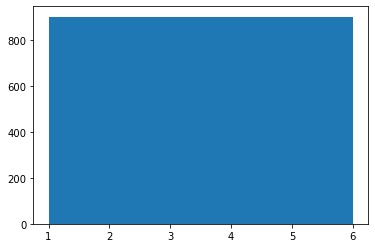

In [30]:
plt.hist(rows, bins = 6)

In [13]:
imread(fns[0])

array([[112, 104, 108, ..., 109, 113, 115],
       [118, 109, 110, ..., 104, 106, 112],
       [121, 112, 109, ..., 106, 101, 102],
       ...,
       [104, 106, 105, ..., 149, 156, 153],
       [109, 103, 101, ..., 152, 144, 144],
       [102, 100, 101, ..., 152, 145, 148]], dtype=uint16)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


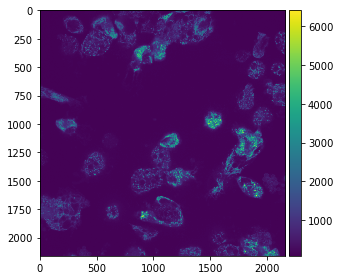

In [15]:
imshow(fns[0])

In [7]:
import sys

In [8]:
sys.path.append('../')
import data_utils

In [9]:
data_utils.size(fns[0])

'243.0 B'

In [21]:
os.stat(os.path.join(image_dir, fns[0]))

os.stat_result(st_mode=33216, st_ino=10, st_dev=54, st_nlink=1, st_uid=30046150, st_gid=30000513, st_size=6579061, st_atime=1661331511, st_mtime=1637774275, st_ctime=1637774275)

In [22]:
from skimage.io import imread, imshow

In [23]:
imread(fns[0])

PermissionError: [Errno 13] Permission denied: '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'